# Digit Recognition Using Machine Learning

## Objective:
Develop a Jupyter notebook that uses a machine learning model to identify and classify
handwritten digits.

## Tasks:

1. Import Libraries
2. Data Loading & PreProcessing
3. Model Selection
4. Training
5. Evaluation
6. Inference

## 1. Import Libraries

In [103]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchinfo import summary

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

import random
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.1+cu117
torchvision version: 0.14.1+cu117


## 2. Data Loading and Pre-Processing

### 2.1 Download & Load Data

In [3]:
data_root = 'data'

In [46]:
type(train_data), type(transforms.ToTensor())

(torchvision.datasets.mnist.MNIST, torchvision.transforms.transforms.ToTensor)

In [45]:
train_data = datasets.MNIST(
    root=data_root, 
    train=True,
    download=True, 
    transform=transforms.ToTensor(),
)

test_data = datasets.MNIST(
    root=data_root,
    train=False, 
    download=True,
    transform=transforms.ToTensor()
)

In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [7]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### 2.2. Visualize random samples

Image shape: torch.Size([1, 28, 28])


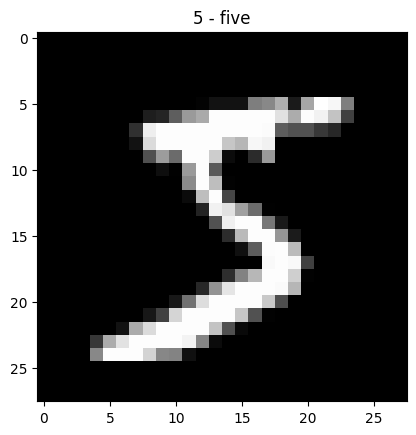

In [11]:
image, label = train_data[0]
print(f'Image shape: {image.shape}')
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label]);

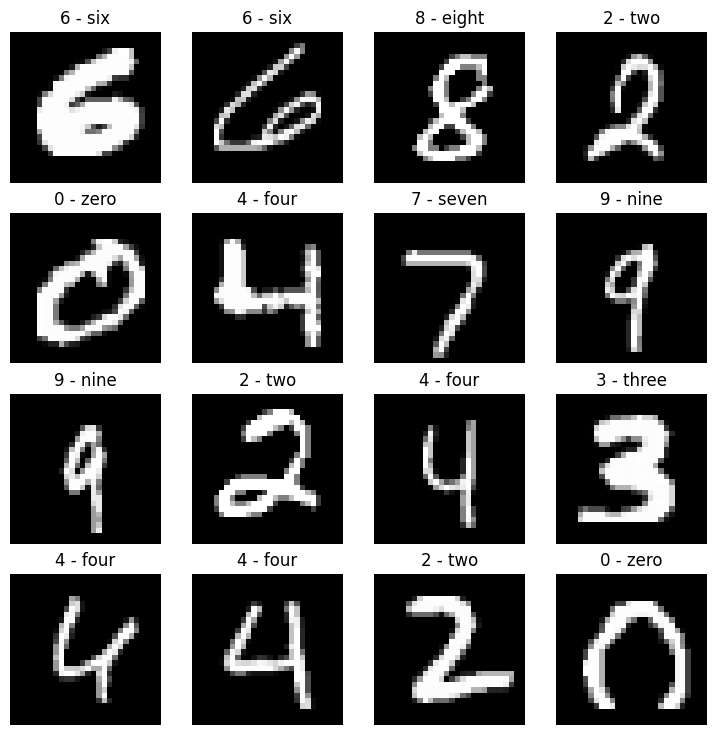

In [12]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False);

### 2.3. Data Loaders

In [15]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f'Dataloaders: {train_dataloader, test_dataloader}')
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fc304fa0760>, <torch.utils.data.dataloader.DataLoader object at 0x7fc304fa0580>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


### 2.4. Verify data loaders with Visualization

In [82]:
def plot_random_image_batch (dataloader): 
    train_features_batch, train_labels_batch = next(iter(dataloader))
    train_features_batch.shape, train_labels_batch.shape

    random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
    img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
    plt.imshow(img[0,:,:], cmap="gray")
    plt.title(class_names[label])
    plt.axis("Off");
    print(f"Image size: {img.shape}")
    print(f"Label: {label}, label size: {label.shape}")

Image size: torch.Size([1, 28, 28])
Label: 3, label size: torch.Size([])


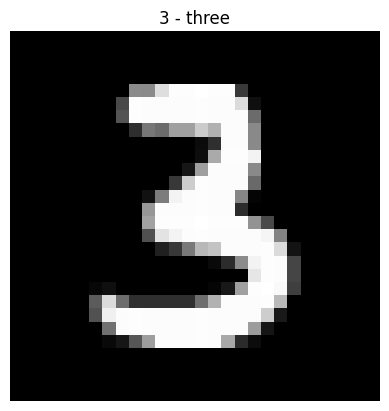

In [86]:
plot_random_image_batch (train_dataloader)

In [48]:
def get_dataloaders(transforms_data: torchvision.transforms = transforms.ToTensor(),
                    BATCH_SIZE: int = 32)-> Tuple[DataLoader, DataLoader]:
    train_data = datasets.MNIST(
        root=data_root, 
        train=True,
        download=True, 
        transform=transforms_data,
    )

    test_data = datasets.MNIST(
        root=data_root,
        train=False, 
        download=True,
        transform=transforms_data,
    )
    
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataloader, test_dataloader

## 3. Model Selection

In [22]:
train_features_batch[0].shape, train_labels_batch[0].shape

(torch.Size([1, 28, 28]), torch.Size([]))

### 3.1. Custom MLP

In [18]:
class MLPModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [26]:
model_mlp = MLPModel(input_shape=784, hidden_units=128, output_shape=len(class_names))
model_mlp

MLPModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [34]:
model_mlp(train_features_batch[0].unsqueeze(0))

tensor([[0.0151, 0.0000, 0.0000, 0.0965, 0.0327, 0.0648, 0.0374, 0.0381, 0.0514,
         0.0084]], grad_fn=<ReluBackward0>)

In [36]:
summary(model=model_mlp,
        input_size=(1,1,28,28),
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
MLPModel (MLPModel)                      [1, 1, 28, 28]       [1, 10]              True
├─Sequential (layer_stack)               [1, 1, 28, 28]       [1, 10]              True
│    └─Flatten (0)                       [1, 1, 28, 28]       [1, 784]             --
│    └─Linear (1)                        [1, 784]             [1, 128]             True
│    └─ReLU (2)                          [1, 128]             [1, 128]             --
│    └─Linear (3)                        [1, 128]             [1, 10]              True
│    └─ReLU (4)                          [1, 10]              [1, 10]              --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

### 3.2. Custom CNN

In [25]:
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
                                    nn.Conv2d(in_channels=input_shape,
                                              out_channels=hidden_units,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_units,
                                              out_channels=hidden_units,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2,
                                                stride=2)
            )
        
        self.block_2 = nn.Sequential(
                                    nn.Conv2d(hidden_units,hidden_units,3,padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(hidden_units,hidden_units,3,padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2)
            )
        self.classifier = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
            )
        
    def forward(self, x:torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [32]:
model_cnn = CNNModel(input_shape=1, hidden_units=10, output_shape=len(class_names))
model_cnn

CNNModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [33]:
model_cnn(train_features_batch[0].unsqueeze(0))

tensor([[ 0.0776,  0.0327, -0.0298, -0.0315, -0.0087,  0.0006, -0.0091, -0.0467,
          0.0237, -0.0552]], grad_fn=<AddmmBackward0>)

In [37]:
summary(model=model_cnn,
        input_size=(1,1,28,28),
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
CNNModel (CNNModel)                      [1, 1, 28, 28]       [1, 10]              True
├─Sequential (block_1)                   [1, 1, 28, 28]       [1, 10, 14, 14]      True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 10, 28, 28]      True
│    └─ReLU (1)                          [1, 10, 28, 28]      [1, 10, 28, 28]      --
│    └─Conv2d (2)                        [1, 10, 28, 28]      [1, 10, 28, 28]      True
│    └─ReLU (3)                          [1, 10, 28, 28]      [1, 10, 28, 28]      --
│    └─MaxPool2d (4)                     [1, 10, 28, 28]      [1, 10, 14, 14]      --
├─Sequential (block_2)                   [1, 10, 14, 14]      [1, 10, 7, 7]        True
│    └─Conv2d (0)                        [1, 10, 14, 14]      [1, 10, 14, 14]      True
│    └─ReLU (1)                          [1, 10, 14, 14]      [1, 10, 14, 14]      --
│    └─Conv2d (2)                  

### 3.3. PreTrained Model

In [117]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_tf = torchvision.models.efficientnet_b0(weights=weights) 

for param in model_tf.features.parameters():
    param.requires_grad = False
    
model_tf.classifier = nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                                 nn.Linear(in_features=1280, 
                                           out_features=len(class_names),
                                           bias=True))

**Different DataLoader since pretrained model needs different input shape**

In [80]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
train_dataloader_v2, test_dataloader_v2 = get_dataloaders(transforms_data = manual_transforms, BATCH_SIZE=4)

Image size: torch.Size([3, 224, 224])
Label: 7, label size: torch.Size([])


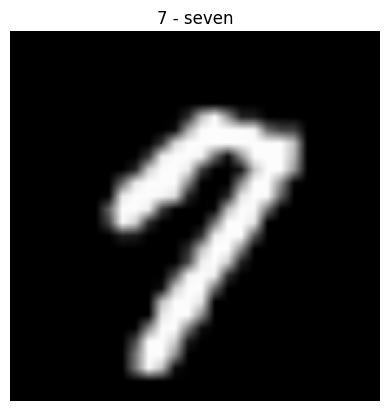

In [88]:
plot_random_image_batch (train_dataloader_v2)

In [90]:
model_pre_trained(next(iter(train_dataloader_v2))[0])

tensor([[-0.0784, -0.1751, -0.1521, -0.2672,  0.1985,  0.2972,  0.1490, -0.2151,
          0.0364,  0.2416],
        [-0.0224, -0.4143, -0.1443,  0.2903,  0.0465, -0.0667,  0.2194,  0.3859,
          0.0527, -0.1532],
        [ 0.2609,  0.1129, -0.4453, -0.1768,  0.2092, -0.0909, -0.0757, -0.0248,
          0.1859,  0.3083],
        [ 0.2879, -0.2971, -0.1263,  0.0989, -0.0811,  0.1213,  0.5030, -0.1060,
          0.0666, -0.1978]], grad_fn=<AddmmBackward0>)

In [91]:
summary(model=model_pre_trained,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 10]              Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112, 112]    False
│    │    └─MBConv (0)                                       [1, 32, 112, 112]    [1, 16, 112, 112]    False
│    └─Sequentia

## 4. Training

In [112]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
        
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [119]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_mlp.parameters(), 
                            lr=0.1)
# model_mlp = model_mlp.to(device)
torch.manual_seed(42)

train_time_start_on_gpu = timer()

results_mlp = train(model=model_mlp,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=5,
               device=device)

train_time_end_on_gpu = timer()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Train time on {device}: {total_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0140 | train_acc: 0.9974 | test_loss: 0.0738 | test_acc: 0.9777
Epoch: 2 | train_loss: 0.0123 | train_acc: 0.9980 | test_loss: 0.0693 | test_acc: 0.9802
Epoch: 3 | train_loss: 0.0112 | train_acc: 0.9984 | test_loss: 0.0720 | test_acc: 0.9791
Epoch: 4 | train_loss: 0.0101 | train_acc: 0.9986 | test_loss: 0.0706 | test_acc: 0.9810
Epoch: 5 | train_loss: 0.0087 | train_acc: 0.9989 | test_loss: 0.0699 | test_acc: 0.9807
Train time on cuda: 20.946 seconds


In [114]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn.parameters(), 
                            lr=0.1)
model_cnn.to(device)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

results_cnn = train(model=model_cnn,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=5,
               device=device)

train_time_end_on_gpu = timer()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Train time on {device}: {total_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3100 | train_acc: 0.8937 | test_loss: 0.0707 | test_acc: 0.9787
Epoch: 2 | train_loss: 0.0725 | train_acc: 0.9768 | test_loss: 0.0573 | test_acc: 0.9801
Epoch: 3 | train_loss: 0.0566 | train_acc: 0.9819 | test_loss: 0.0479 | test_acc: 0.9842
Epoch: 4 | train_loss: 0.0485 | train_acc: 0.9849 | test_loss: 0.0532 | test_acc: 0.9819
Epoch: 5 | train_loss: 0.0430 | train_acc: 0.9866 | test_loss: 0.0466 | test_acc: 0.9840
Train time on cuda: 32.156 seconds


In [122]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_tf.parameters(), 
                            lr=0.1)
model_tf.to(device)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

results_tf = train(model=model_tf,
               train_dataloader=train_dataloader_v2,
               test_dataloader=test_dataloader_v2,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=5,
               device=device)

train_time_end_on_gpu = timer()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Train time on {device}: {total_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [125]:
# 1. Make predictions with trained model
y_preds = []
model_mlp.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_mlp(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

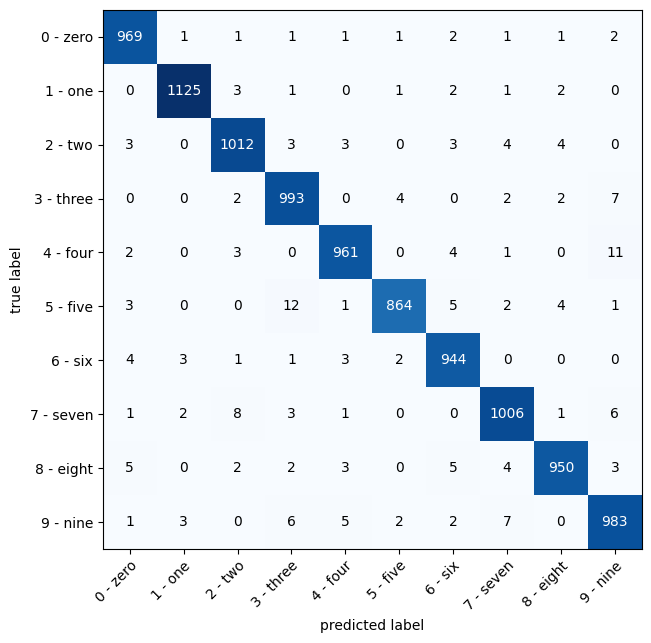

In [126]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [127]:
from sklearn.metrics import classification_report
print(classification_report(test_data.targets, y_pred_tensor, target_names=class_names))

              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.98       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.98      0.98      0.98      1032
   3 - three       0.97      0.98      0.98      1010
    4 - four       0.98      0.98      0.98       982
    5 - five       0.99      0.97      0.98       892
     6 - six       0.98      0.99      0.98       958
   7 - seven       0.98      0.98      0.98      1028
   8 - eight       0.99      0.98      0.98       974
    9 - nine       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## 4. Inference

In [134]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [135]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [138]:
pred_probs= make_predictions(model=model_mlp, 
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

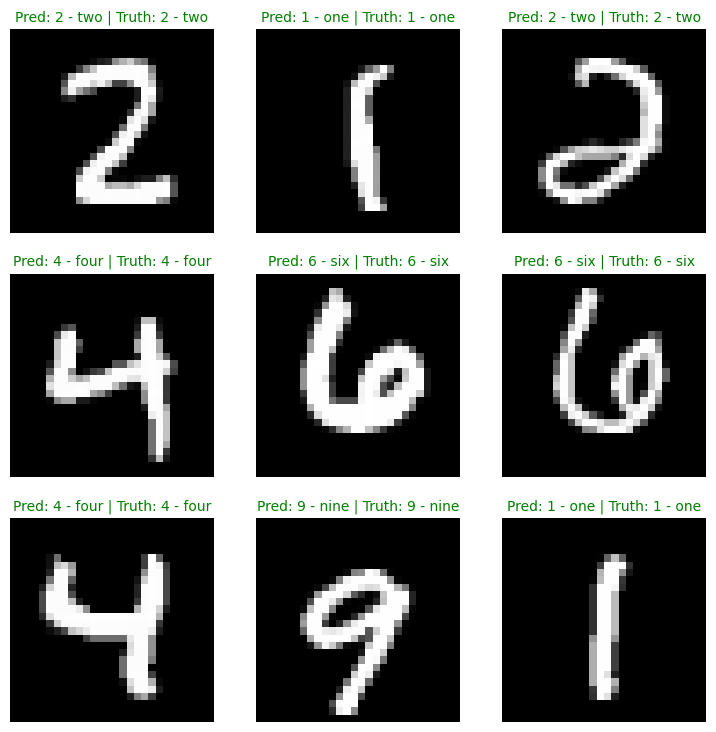

In [139]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

In [129]:
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (28, 28),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

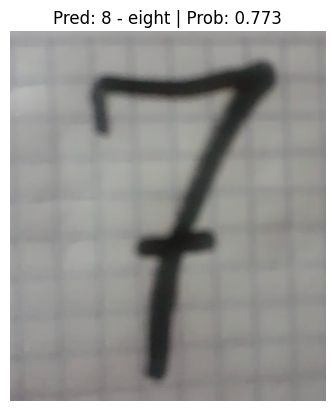

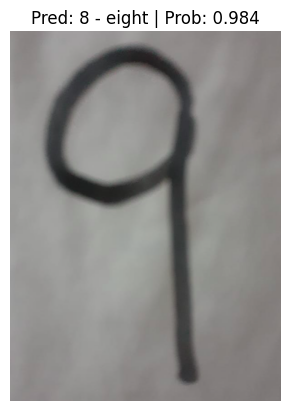

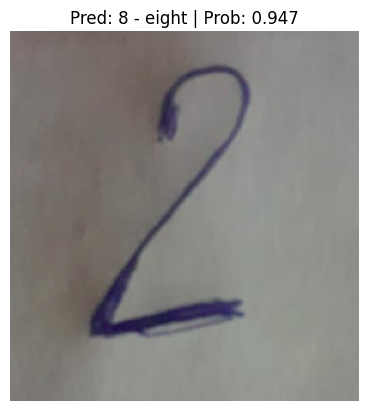

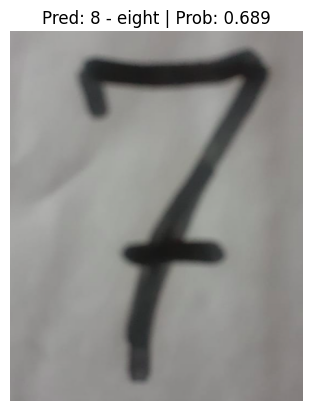

In [133]:
import random
import glob

image_paths = glob.glob('images/*')

# Make predictions on and plot the images
for image_path in image_paths:
    pred_and_plot_image(model=model_mlp, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(28, 28))

In [ ]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results